In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import random
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import Sequential

In [19]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [20]:
train_df = pd.read_csv('Datensatz/Train.csv')
test_df = pd.read_csv('Datensatz/Test.csv')

In [21]:
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [22]:
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [23]:
train_df['Path'] = train_df['Path'].apply(lambda x: 'Datensatz/' + x)
test_df['Path'] = test_df['Path'].apply(lambda x: 'Datensatz/' + x)

In [24]:
random.choice(train_df['Path'].tolist())

'Datensatz/Train/26/00026_00007_00007.png'

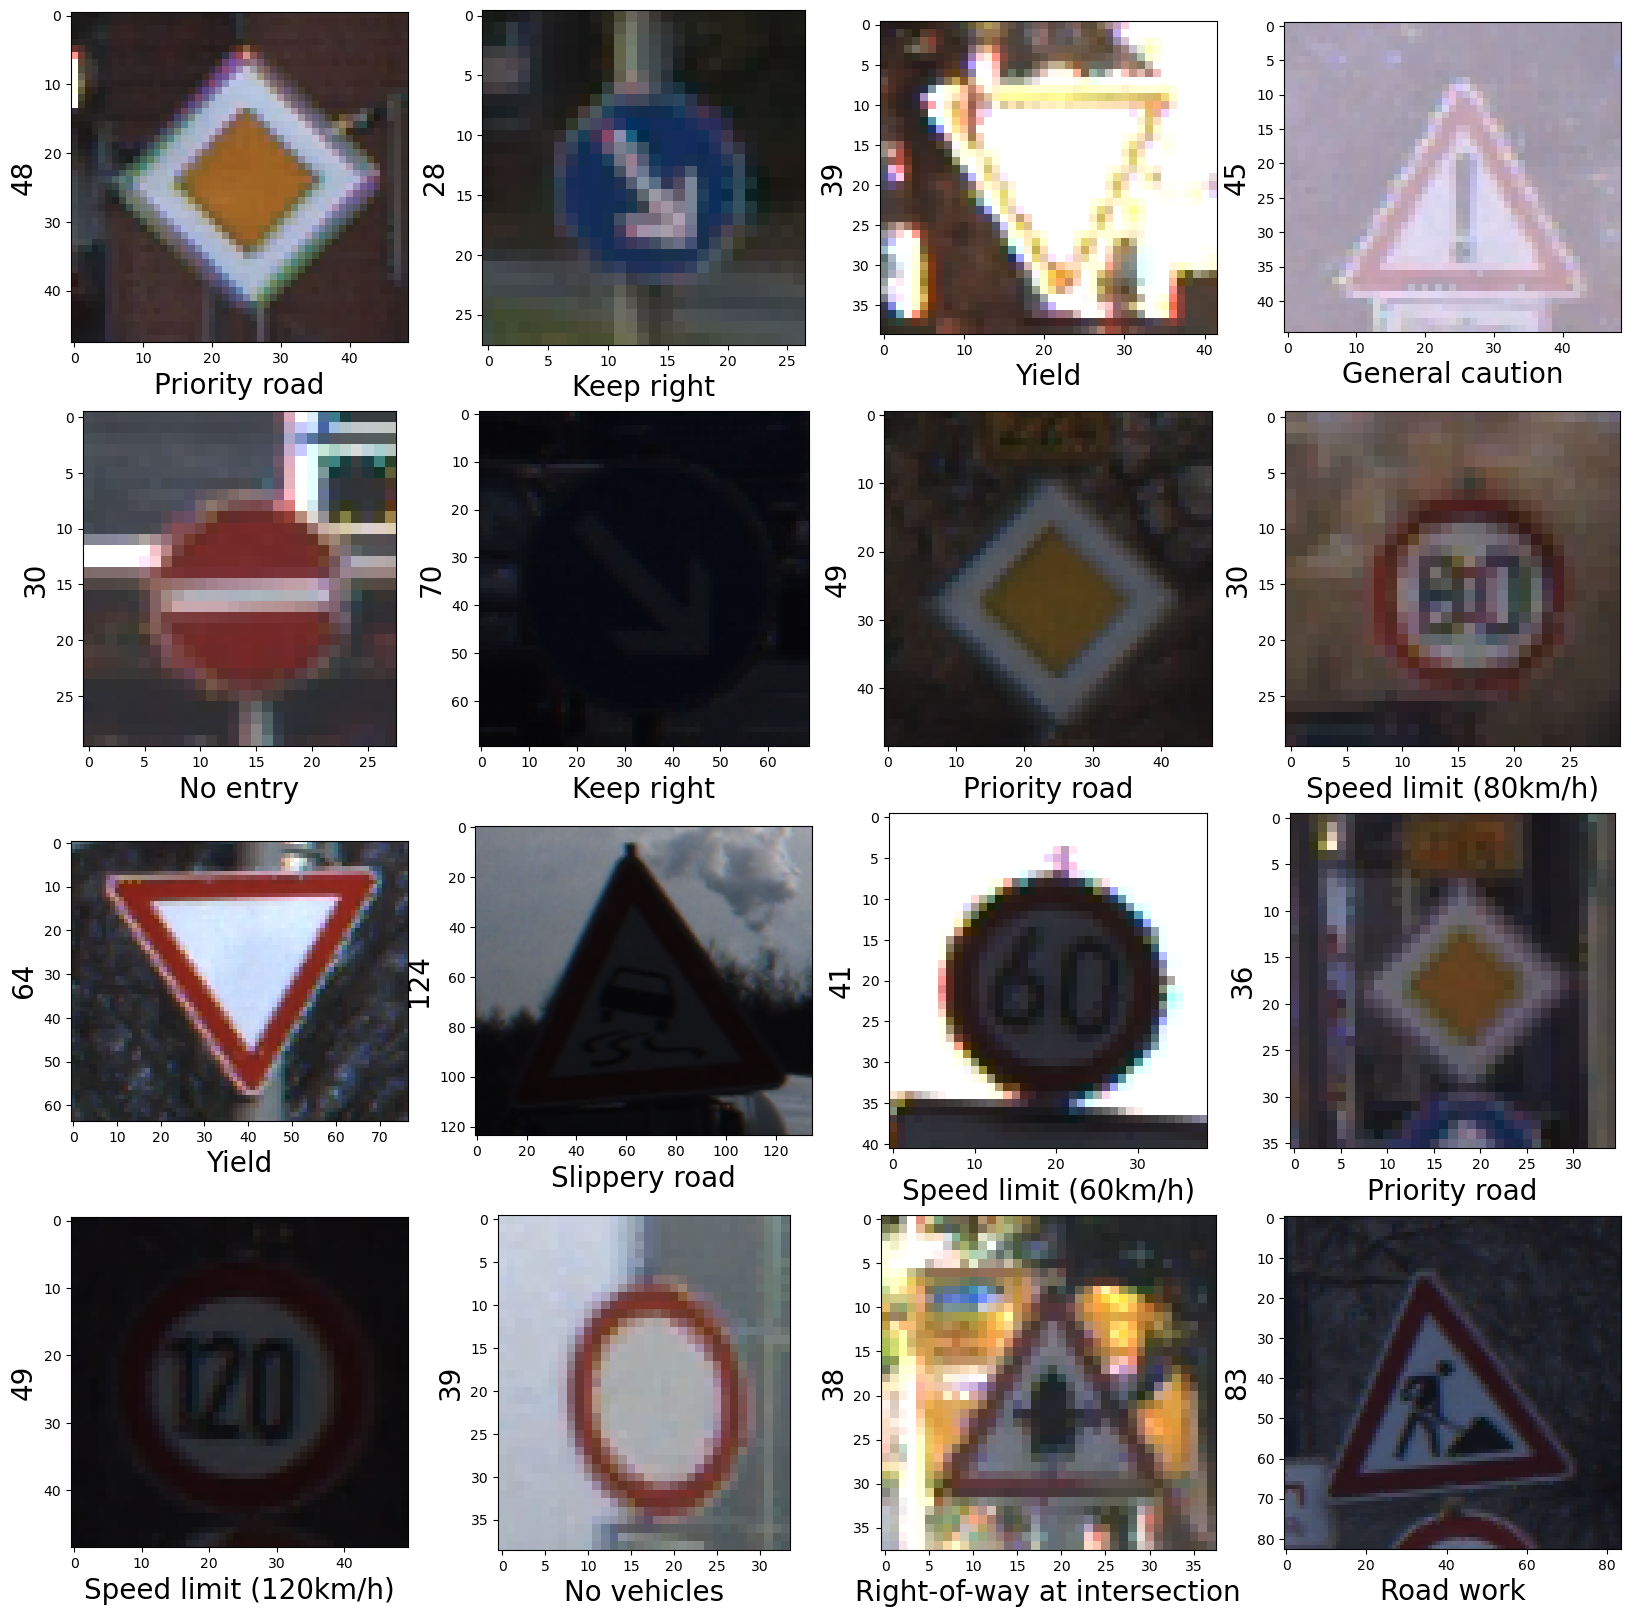

In [8]:
random_sample = train_df.sample(16)
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    img = plt.imread(random_sample['Path'].values.tolist()[i-1])
    plt.imshow(img)
    plt.grid(False)
    plt.xlabel(classes[random_sample['ClassId'].values.tolist()[i-1]], fontsize = 20)
    plt.ylabel(img.shape[0], fontsize = 20)

In [9]:
train_data = train_df.sample(frac=0.8,random_state=42)
val_data = train_df.drop(train_data.index)

NUM_CLASSES = len(classes)
IMG_SIZE = 32

def preprocess_image(image):
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image/255
    return image

def load_data(data):
    X = []
    y = []
    for path, label in zip(data['Path'].values.tolist(), data['ClassId'].values.tolist()):
        image = cv2.imread(path)
        image = preprocess_image(image)
        X.append(image)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = load_data(train_data)
X_val, y_val = load_data(val_data)
X_test, y_test = load_data(test_df)

In [10]:
print(f'The shape of X_train : {X_train.shape}')
print(f'The shape of X_test : {y_train.shape}')

The shape of X_train : (31367, 32, 32, 3)
The shape of X_test : (31367,)


In [28]:
X_train

array([[[[0.15686275, 0.22352941, 0.41176471],
         [0.14901961, 0.21176471, 0.37254902],
         [0.1372549 , 0.2       , 0.30588235],
         ...,
         [0.17254902, 0.32941176, 0.54509804],
         [0.19607843, 0.34117647, 0.54509804],
         [0.2745098 , 0.44705882, 0.70588235]],

        [[0.18039216, 0.25882353, 0.41568627],
         [0.16078431, 0.23137255, 0.36078431],
         [0.13333333, 0.21176471, 0.34901961],
         ...,
         [0.09411765, 0.22745098, 0.37254902],
         [0.08627451, 0.20784314, 0.26666667],
         [0.12941176, 0.27843137, 0.36470588]],

        [[0.18431373, 0.2745098 , 0.44705882],
         [0.14509804, 0.25098039, 0.38039216],
         [0.11764706, 0.23529412, 0.39215686],
         ...,
         [0.10588235, 0.22745098, 0.35294118],
         [0.07843137, 0.20392157, 0.2627451 ],
         [0.08627451, 0.21960784, 0.29019608]],

        ...,

        [[0.12156863, 0.2       , 0.36862745],
         [0.14901961, 0.21568627, 0.36078431]

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [13]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


2023-04-23 13:38:49.637719: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


981/981 [==============================] - 8s 8ms/step - loss: 1.7712 - accuracy: 0.4854 - val_loss: 0.4203 - val_accuracy: 0.8763
Epoch 2/10
981/981 [==============================] - 8s 9ms/step - loss: 0.3969 - accuracy: 0.8753 - val_loss: 0.1537 - val_accuracy: 0.9631
Epoch 3/10
981/981 [==============================] - 10s 10ms/step - loss: 0.2023 - accuracy: 0.9384 - val_loss: 0.0796 - val_accuracy: 0.9811
Epoch 4/10
981/981 [==============================] - 11s 11ms/step - loss: 0.1279 - accuracy: 0.9623 - val_loss: 0.0676 - val_accuracy: 0.9819
Epoch 5/10
981/981 [==============================] - 11s 11ms/step - loss: 0.0987 - accuracy: 0.9700 - val_loss: 0.0504 - val_accuracy: 0.9865
Epoch 6/10
981/981 [==============================] - 11s 11ms/step - loss: 0.0787 - accuracy: 0.9756 - val_loss: 0.0337 - val_accuracy: 0.9920
Epoch 7/10
981/981 [==============================] - 11s 11ms/step - loss: 0.0647 - accuracy: 0.9796 - val_loss: 0.0525 - val_accuracy: 0.9875
Epoch 8

In [14]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
labels = test_df["ClassId"].values
model.evaluate(X_test, labels)

395/395 [==============================] - 2s 4ms/step - loss: 0.2331 - accuracy: 0.9606


[0.2330586314201355, 0.9606492519378662]

In [30]:
true_pred = np.where(y_pred_classes == labels)[0]
print("Number of false predictions = ", len(true_pred))

Number of false predictions =  12133


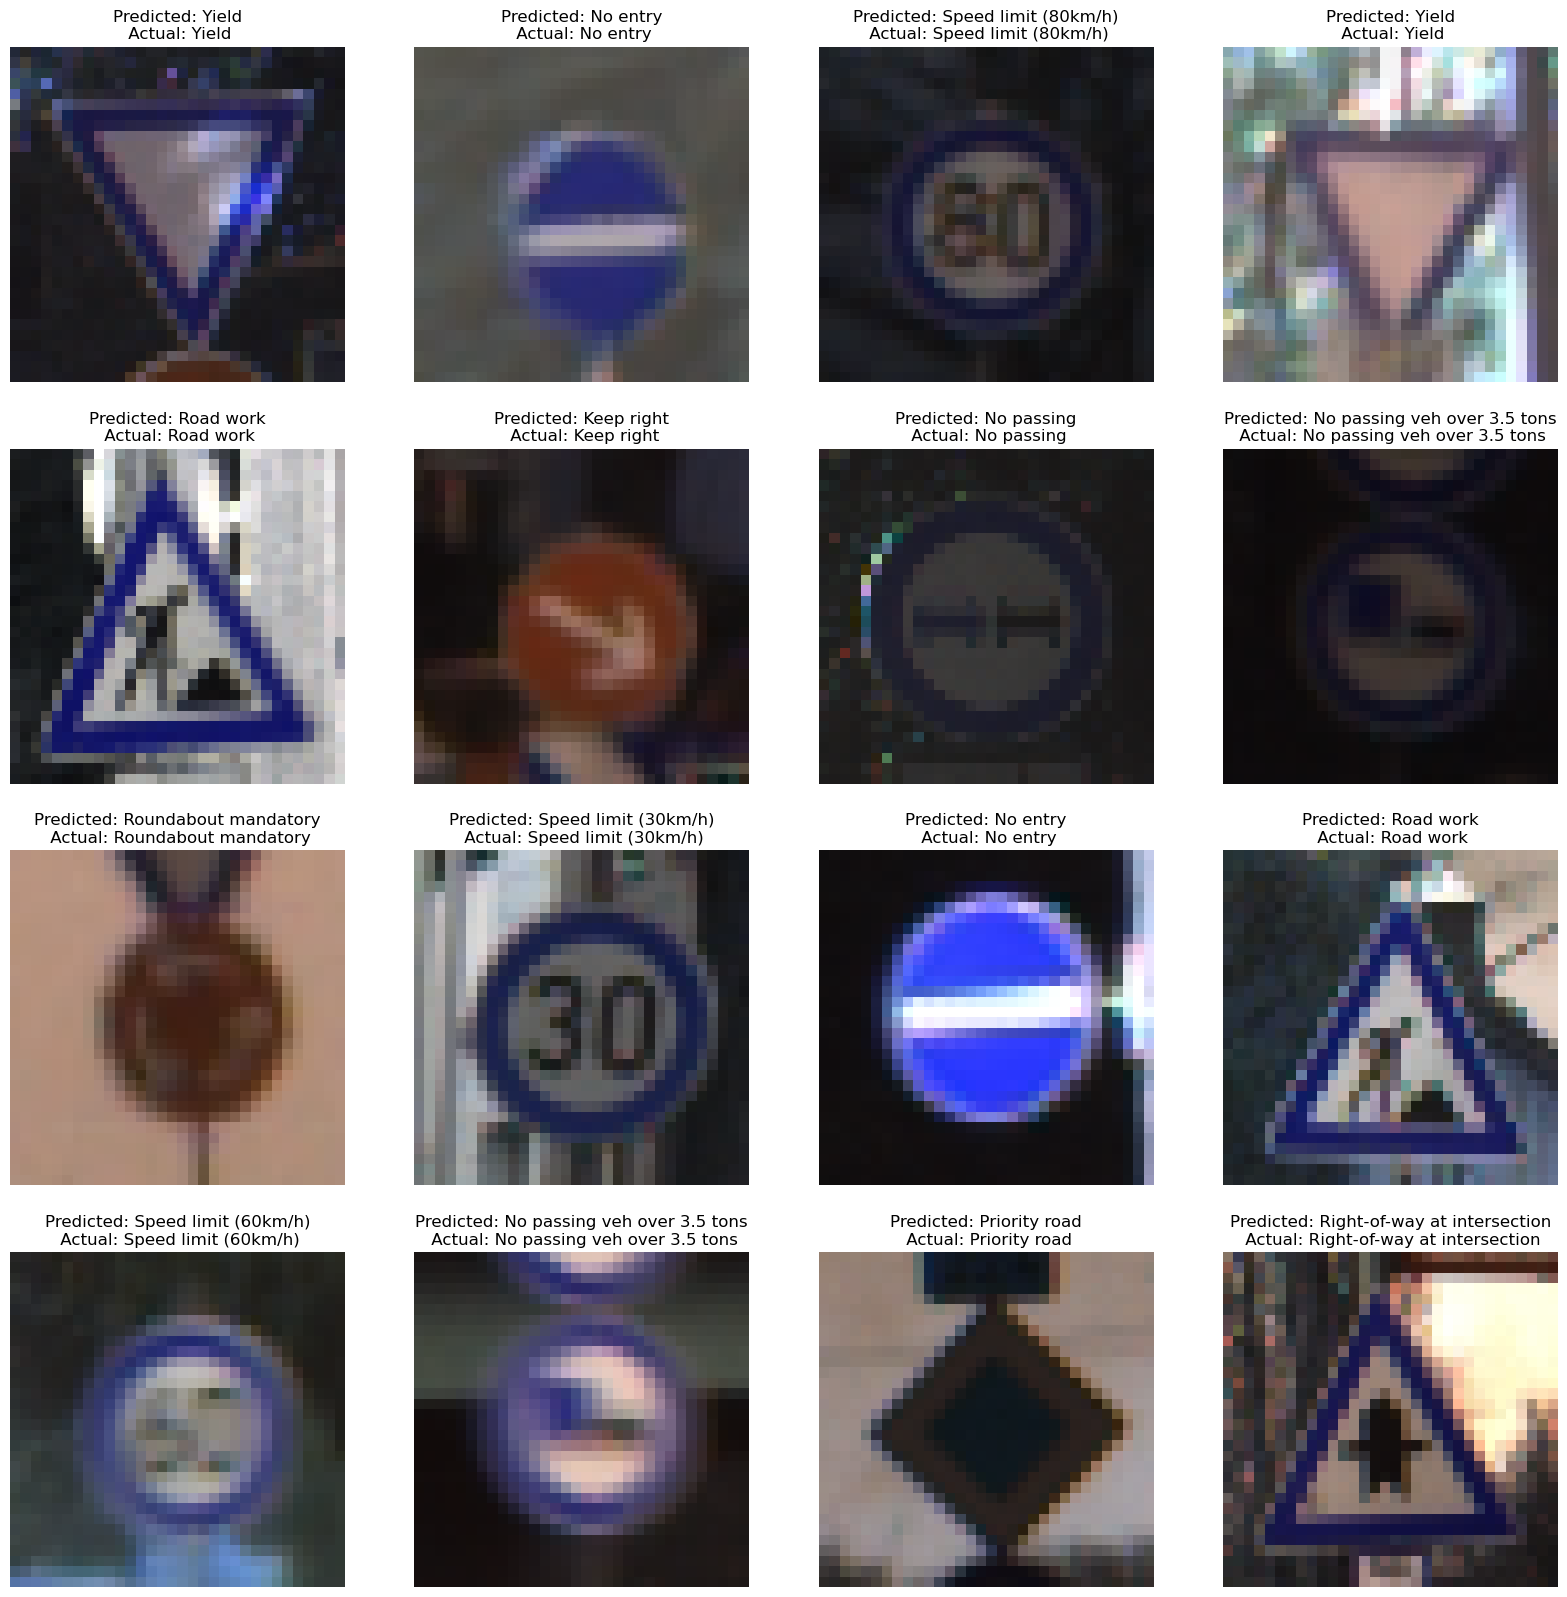

In [40]:
np.random.seed(42)
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
for i, index in enumerate(np.random.choice(true_pred, 16, replace=False)):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_classes[index]]}\n Actual: {classes[labels[index]]}")
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.2)

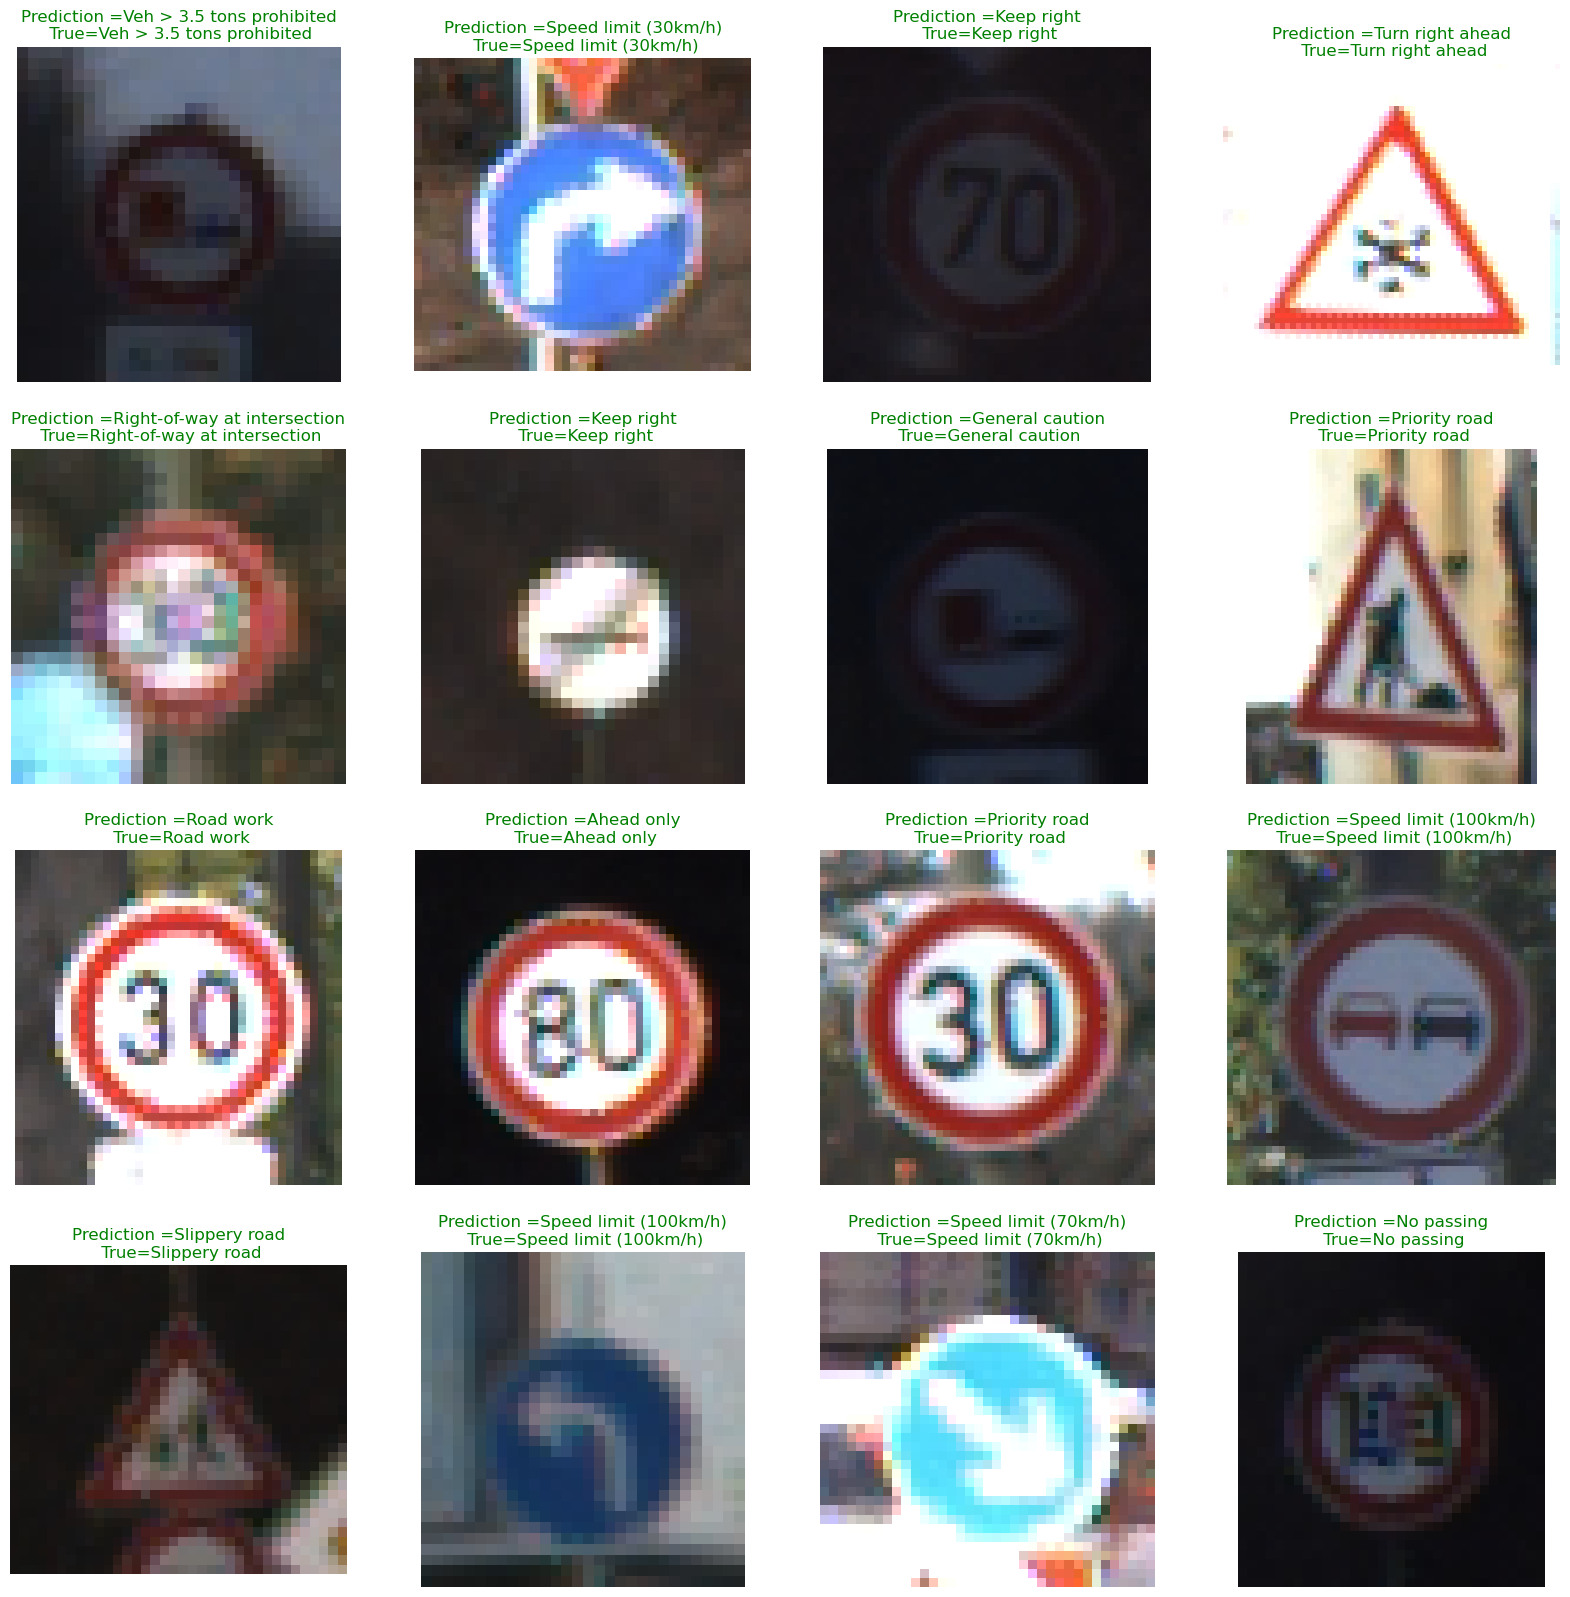

In [29]:
sample_test = test_df.sample(16)

fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
for i in np.arange(0, 16):
    img = plt.imread(sample_test['Path'].values.tolist()[i])
    axs[i].imshow(img)
    if classes[y_pred_classes[i]] == classes[labels[i]]:
        color = "green"
    else:
        color = "red"
    axs[i].set_title("Prediction ={}\n True={}".format(classes[y_pred_classes[i]], classes[labels[i]]), color=color)
    
    axs[i].axis('off')
plt.subplots_adjust(wspace=.2)

In [16]:
# false predicted indexes
false_pred = np.where(y_pred_classes != labels)[0]
print("Number of false predictions = ", len(false_pred))

Number of false predictions =  497


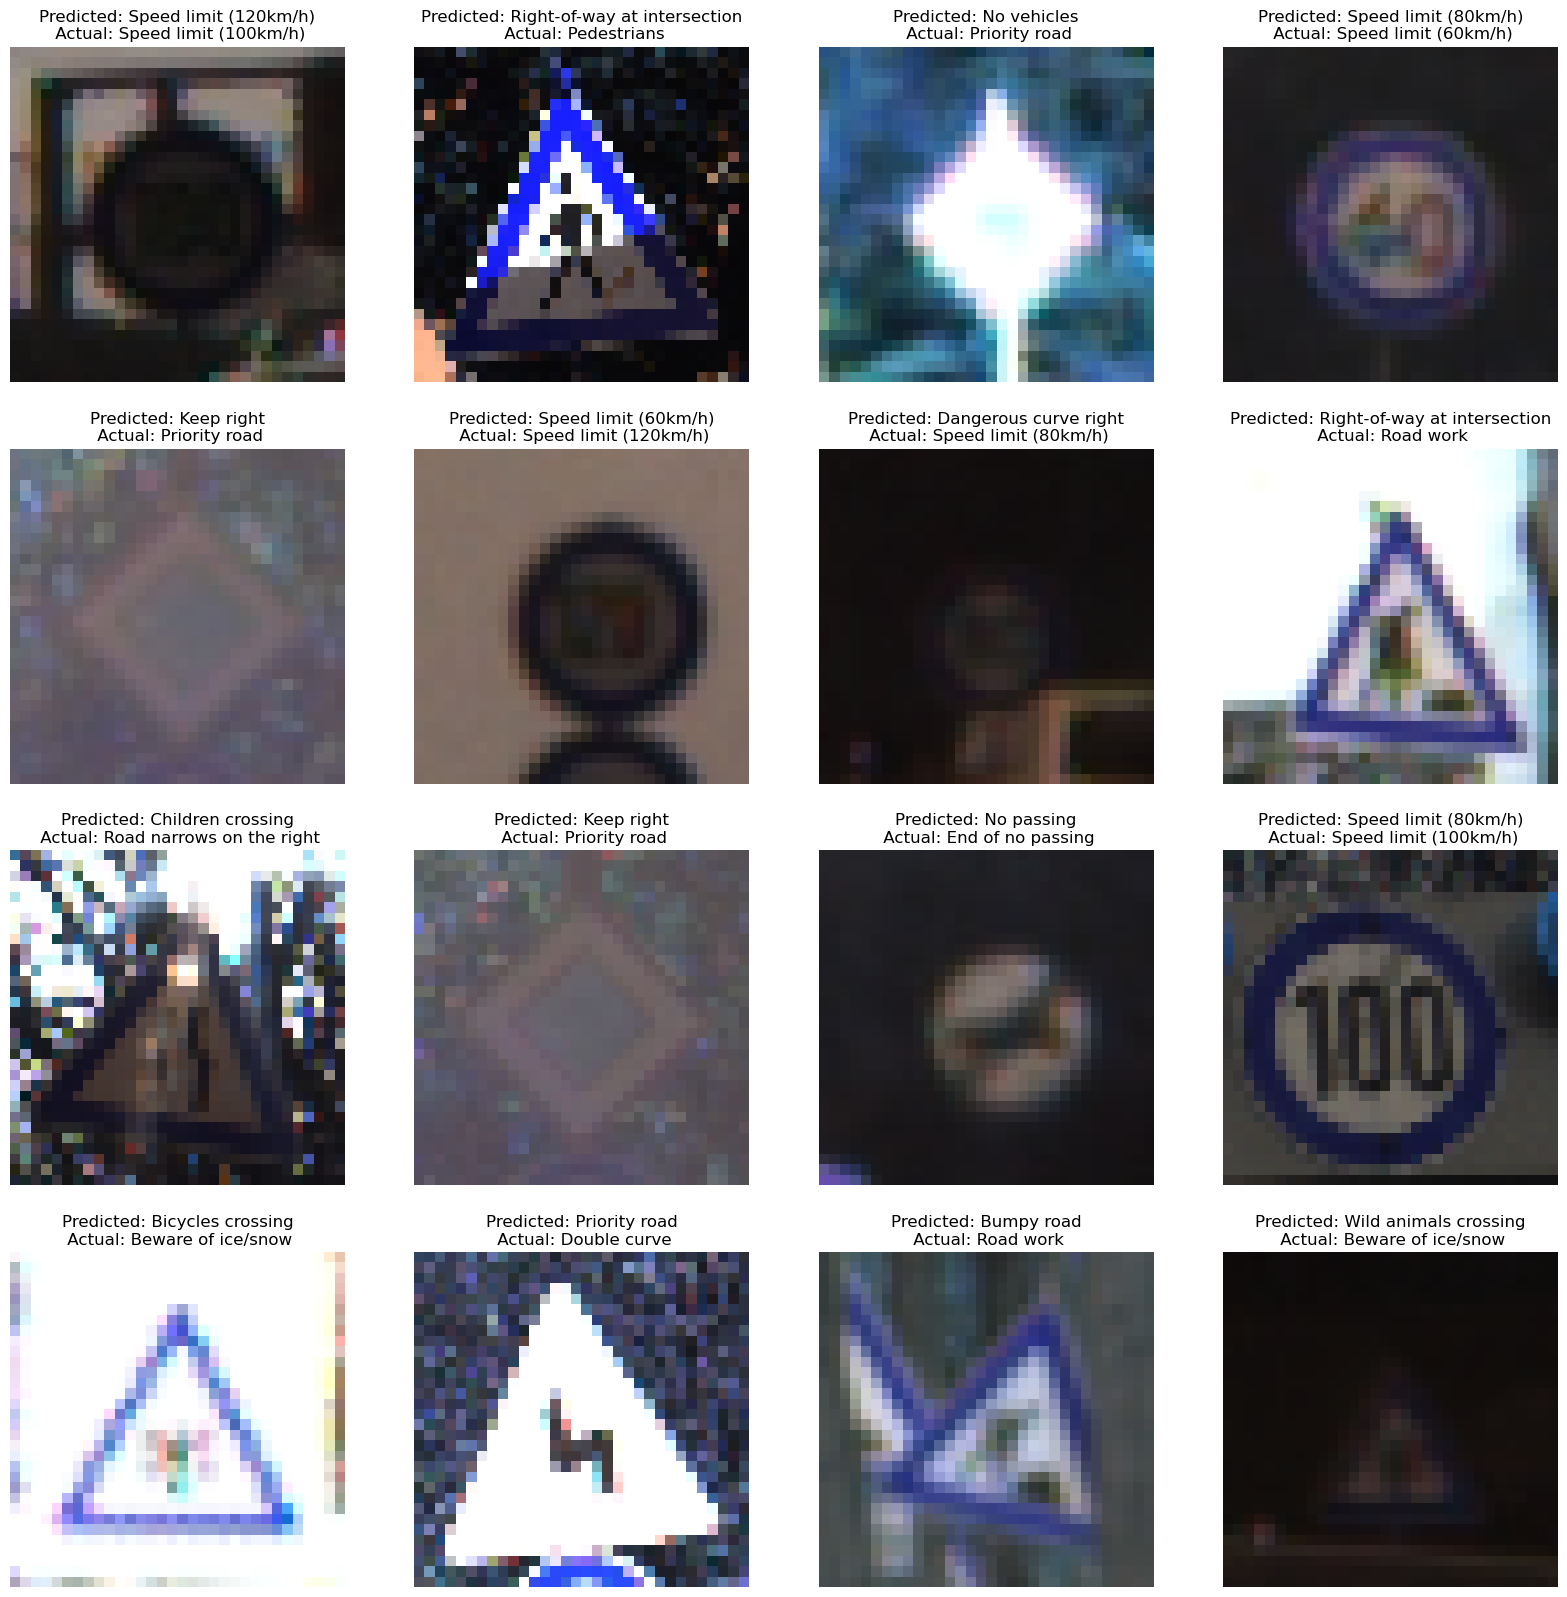

In [41]:
fig, axs = plt.subplots(4,4, figsize=(20, 20))
axs = axs.ravel()
for i, index in enumerate(np.random.choice(false_pred, 16, replace=False)):
    axs[i].imshow(X_test[index])
    axs[i].set_title(f"Predicted: {classes[y_pred_classes[index]]}\n Actual: {classes[labels[index]]}")
    axs[i].axis('off')
plt.subplots_adjust(wspace=0.2)